# Лабораторная работа №5: "Ансамбли моделей машинного обучения".

## Загрузка датасета

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
from sklearn.neural_network import MLPRegressor
from gmdhpy import gmdh
from warnings import simplefilter

simplefilter('ignore')

In [2]:
data = pd.read_csv('laptop_price_preprocessed.csv')
data.head()

,laptop_ID,Company,Product,TypeName,Inches,Ram_GB,OpSys,Weight_kg,Price_euros,ScreenType,...,ScreenRes,Cpu_type,Cpu_GHz,Gpu_producer,Gpu_model,Memory1_GB,Memory1_type,Memory2_GB,Memory2_type,Memory2
0,1,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,IPS Panel Retina Display,...,2560x1600,Intel Core i5,2.3,Intel,Iris Plus Graphics 640,128,SSD,0,-,-
1,2,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,-,...,1440x900,Intel Core i5,1.8,Intel,HD Graphics 6000,128,Flash Storage,0,-,-
2,3,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,...,1920x1080,Intel Core i5 7200U,2.5,Intel,HD Graphics 620,256,SSD,0,-,-
3,4,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,IPS Panel Retina Display,...,2880x1800,Intel Core i7,2.7,AMD,Radeon Pro 455,512,SSD,0,-,-
4,5,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,IPS Panel Retina Display,...,2560x1600,Intel Core i5,3.1,Intel,Iris Plus Graphics 650,256,SSD,0,-,-


## Кодирование категориальных признаков

In [3]:
category_cols = ['Memory1_type', 'Memory2_type', 'Company', 'Product', 'TypeName', 'OpSys', 
                 'ScreenType', 'Cpu_type', 'Gpu_producer', 'Gpu_model']

print('Количество уникальных значений\n')
for col in category_cols:
    print(f'{col}: {data[col].unique().size}')

Количество уникальных значений

Memory1_type: 4
Memory2_type: 4
Company: 19
Product: 618
TypeName: 6
OpSys: 9
ScreenType: 21
Cpu_type: 93
Gpu_producer: 4
Gpu_model: 110


In [4]:
remove_cols = ['Product', 'Gpu_model', 'Cpu_type']
for col in remove_cols:
    category_cols.remove(col)
data = pd.get_dummies(data, columns=category_cols)

In [5]:
data.drop(remove_cols, axis=1, inplace=True)
data.drop(['laptop_ID', 'ScreenRes', 'Memory2'], axis=1, inplace=True)
data.describe()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,ScreenType_Quad HD+,ScreenType_Quad HD+ / Touchscreen,ScreenType_Touchscreen,ScreenType_Touchscreen / 4K Ultra HD,ScreenType_Touchscreen / Full HD,ScreenType_Touchscreen / Quad HD+,Gpu_producer_AMD,Gpu_producer_ARM,Gpu_producer_Intel,Gpu_producer_Nvidia
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,15.034880,8.443200,2.046152,1132.177480,1897.272000,1072.256000,2.303856,447.180800,174.675200,0.055200,...,0.002400,0.012000,0.025600,0.000800,0.000800,0.000800,0.133600,0.000800,0.552000,0.313600
std,1.416838,5.121929,0.669436,703.965444,491.854703,283.172078,0.502772,367.670259,411.340426,0.228462,...,0.048951,0.108929,0.158002,0.028284,0.028284,0.028284,0.340358,0.028284,0.497488,0.464142
min,10.100000,2.000000,0.690000,174.000000,1366.000000,768.000000,0.900000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,4.000000,1.500000,600.425000,1600.000000,900.000000,2.000000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.600000,8.000000,2.040000,985.000000,1920.000000,1080.000000,2.500000,256.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.600000,8.000000,2.310000,1489.747500,1920.000000,1080.000000,2.700000,512.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,18.400000,64.000000,4.700000,6099.000000,3840.000000,2160.000000,3.600000,2048.000000,2048.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
data.head()

,Inches,Ram_GB,Weight_kg,Price_euros,ScreenWidth,ScreenHeight,Cpu_GHz,Memory1_GB,Memory2_GB,Memory1_type_Flash Storage,...,ScreenType_Quad HD+,ScreenType_Quad HD+ / Touchscreen,ScreenType_Touchscreen,ScreenType_Touchscreen / 4K Ultra HD,ScreenType_Touchscreen / Full HD,ScreenType_Touchscreen / Quad HD+,Gpu_producer_AMD,Gpu_producer_ARM,Gpu_producer_Intel,Gpu_producer_Nvidia
0,13.3,8,1.37,1339.69,2560,1600,2.3,128,0,0,...,0,0,0,0,0,0,0,0,1,0
1,13.3,8,1.34,898.94,1440,900,1.8,128,0,1,...,0,0,0,0,0,0,0,0,1,0
2,15.6,8,1.86,575.00,1920,1080,2.5,256,0,0,...,0,0,0,0,0,0,0,0,1,0
3,15.4,16,1.83,2537.45,2880,1800,2.7,512,0,0,...,0,0,0,0,0,0,1,0,0,0
4,13.3,8,1.37,1803.60,2560,1600,3.1,256,0,0,...,0,0,0,0,0,0,0,0,1,0


## Корреляционный анализ

In [7]:
print('Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука')
best_params = data.corr()['Price_euros'].map(abs).sort_values(ascending=False)[1:]
best_params = best_params[best_params.values > 0.35]
best_params

Признаки, имеющие максимальную по модулю корреляцию с ценой ноутбука


Ram_GB                 0.743141
TypeName_Notebook      0.555495
ScreenWidth            0.553660
ScreenHeight           0.550213
Memory1_type_SSD       0.505318
ScreenType_-           0.435191
Cpu_GHz                0.431697
Memory1_type_HDD       0.425687
TypeName_Gaming        0.377151
Gpu_producer_Nvidia    0.351031
Name: Price_euros, dtype: float64

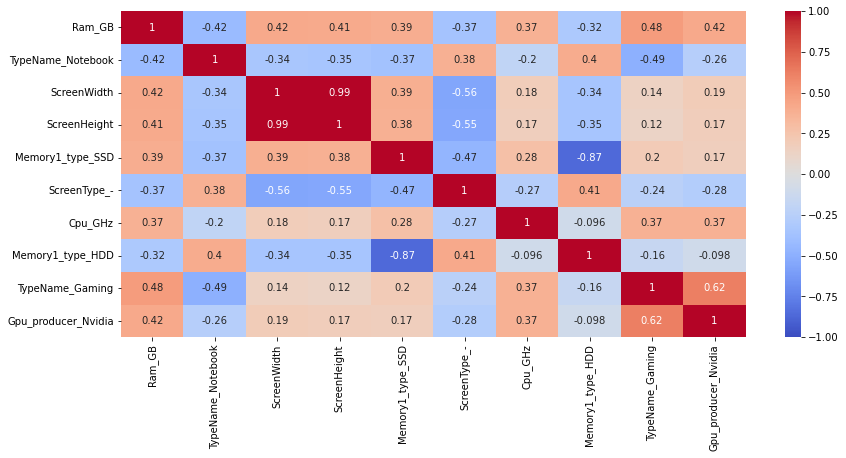

In [8]:
plt.figure(figsize=(14, 6))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

In [9]:
best_params = best_params.drop(['ScreenHeight', 'Memory1_type_SSD', 'ScreenType_-', 'Gpu_producer_Nvidia'])

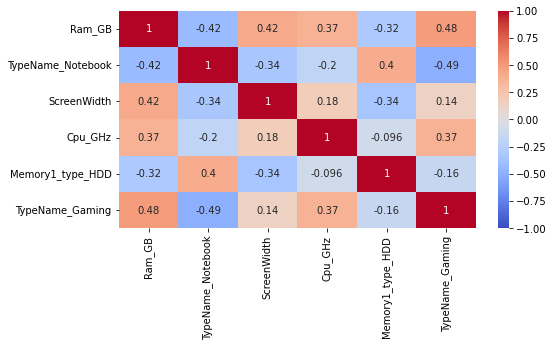

In [10]:
plt.figure(figsize=(8, 4))
sns.heatmap(data[best_params.index].corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

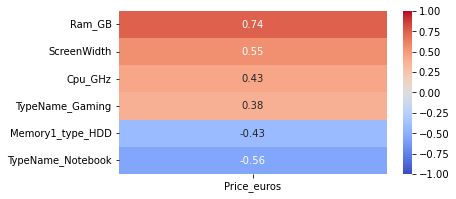

In [11]:
plt.figure(figsize=(6, 3))
sns.heatmap(pd.DataFrame(data[np.append(best_params.index.values, 'Price_euros')].corr()['Price_euros'].sort_values(ascending=False)[1:]), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

## Разделение выборки на обучающую и тестовую

In [12]:
y = data['Price_euros']
X = data[best_params.index]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Масштабирование данных

In [ ]:
scaler = StandardScaler().fit(x_train)
x_train_scaled = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_train.columns)

## Метрики

In [39]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

## Модель №1: Случайный лес

In [40]:
print_metrics(y_test, RandomForestRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.6842978189655353
MSE: 136700.47614728688
MAE: 253.06780287849978


### Подбор гиперпараметров

In [14]:
rf = RandomForestRegressor(random_state=17)
params = {'n_estimators': [100, 1000], 'criterion': ['squared_error', 'absolute_error', 'poisson'], 
          'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=rf, cv=5, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'absolute_error', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 1000}


In [15]:
best_rf = grid_cv.best_estimator_
best_rf.fit(x_train, y_train)
y_pred_rf = best_rf.predict(x_test)
print_metrics(y_test, y_pred_rf)

R^2: 0.6898203012827298
MSE: 134309.21625861025
MAE: 252.41492530666685


## Модель №2: Градиентный бустинг

In [41]:
print_metrics(y_test, GradientBoostingRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.6940296765051565
MSE: 132486.53769711652
MAE: 258.8073464450384


### Подбор гиперпараметров

In [17]:
gb = GradientBoostingRegressor(random_state=17)
params = {'loss': ['squared_error', 'absolute_error', 'huber'], 'n_estimators': [10, 50, 100, 200], 
          'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'], 'min_samples_leaf': [1, 3, 5]}
grid_cv = GridSearchCV(estimator=gb, cv=5, param_grid=params, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'criterion': 'friedman_mse', 'loss': 'huber', 'min_samples_leaf': 1, 'n_estimators': 100}


In [18]:
best_gb = grid_cv.best_estimator_
best_gb.fit(x_train, y_train)
y_pred_gb = best_gb.predict(x_test)
print_metrics(y_test, y_pred_gb)

R^2: 0.7013333844767404
MSE: 129323.99902194891
MAE: 253.7859718910538


## Модель №3: Стекинг

In [24]:
dataset = Dataset(x_train, y_train, x_test)

In [27]:
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, 
                     parameters={'criterion': 'absolute_error', 'n_estimators': 1000, 'random_state': 17}, name='rf')
model_gb = Regressor(dataset=dataset, estimator=GradientBoostingRegressor, 
                     parameters={'loss': 'huber', 'random_state': 17}, name='rf')

In [28]:
pipeline = ModelsPipeline(model_lr, model_rf)
stack_ds = pipeline.stack(k=10, seed=1)
stacker = Regressor(dataset=stack_ds, estimator=GradientBoostingRegressor)
results = stacker.validate(k=10, scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [191.39424868214826, 223.5971668487191, 216.86376824238184, 272.97770520828004, 275.15017993431206, 225.94857678271197, 236.4669684146994, 268.2067712261299, 198.22714693578052, 262.2396119721167]
Mean accuracy: 237.10721442472794
Standard Deviation: 29.413190351082335
Variance: 865.1357666290029


In [29]:
y_pred_stack = stacker.predict()
print_metrics(y_test, y_pred_stack)

R^2: 0.7207185369761542
MSE: 120930.14007496767
MAE: 247.18161038788267


## Модель №4: Многослойный персептрон

In [48]:
print_metrics(y_test, MLPRegressor(random_state=17).fit(x_train, y_train).predict(x_test))

R^2: 0.3933464482443907
MSE: 262683.73918006354
MAE: 406.8932580917785


### Подбор гиперпараметров

In [52]:
mlp = MLPRegressor(random_state=17)
params = {'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(100,), (50, 30,), (100, 40,)], 
          'alpha': [1e-4, 3e-4, 5e-4], 'max_iter': [500, 1000]}
grid_cv = GridSearchCV(estimator=mlp, cv=5, param_grid=params, n_jobs=-1, scoring='r2')
grid_cv.fit(x_train, y_train)
print(grid_cv.best_params_)

{'alpha': 0.0003, 'hidden_layer_sizes': (50, 30), 'max_iter': 500, 'solver': 'lbfgs'}


In [53]:
best_mlp = grid_cv.best_estimator_
best_mlp.fit(x_train, y_train)
y_pred_mlp = best_mlp.predict(x_test)
print_metrics(y_test, y_pred_mlp)

R^2: 0.6422646017371612
MSE: 154901.0498344665
MAE: 288.659695272951


## Модель №5: Метод группового учёта аргументов

In [35]:
gm = gmdh.Regressor(n_jobs=-1)
gm.fit(np.array(x_train_scaled), np.array(y_train))
y_pred_gm = gm.predict(np.array(x_test_scaled))
print()
print_metrics(y_test, y_pred_gm)

train layer0 in 0.01 sec
train layer1 in 0.05 sec
train layer2 in 0.04 sec
train layer3 in 0.05 sec
train layer4 in 0.04 sec
train layer5 in 0.05 sec
train layer6 in 0.04 sec
train layer7 in 0.04 sec
train layer8 in 0.03 sec

R^2: 0.6642449299187112
MSE: 145383.4680475877
MAE: 274.30940411915725


## Сравнение моделей

In [54]:
print("Случайный лес")
print_metrics(y_test, y_pred_rf)

print("\nГрадиентный бустинг")
print_metrics(y_test, y_pred_gb)

print("\nСтекинг")
print_metrics(y_test, y_pred_stack)

print("\nМногослойный персептрон")
print_metrics(y_test, y_pred_mlp)

print("\nМетод группового учёта аргументов")
print_metrics(y_test, y_pred_gm)

Случайный лес
R^2: 0.6898203012827298
MSE: 134309.21625861025
MAE: 252.41492530666685

Градиентный бустинг
R^2: 0.7013333844767404
MSE: 129323.99902194891
MAE: 253.7859718910538

Стекинг
R^2: 0.7207185369761542
MSE: 120930.14007496767
MAE: 247.18161038788267

Многослойный персептрон
R^2: 0.6422646017371612
MSE: 154901.0498344665
MAE: 288.659695272951

Метод группового учёта аргументов
R^2: 0.6642449299187112
MSE: 145383.4680475877
MAE: 274.30940411915725
